<a href="https://www.kaggle.com/code/artemfedorov/eda-notebook?scriptVersionId=120090802" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **EDA Notebook**
This notebook was used for data exploration tasks only and didn't contribute any direct output to final submission. I tried to find some insights for the data. Not all of them were exploited due to lack of time, but I will anyway keep the code here. An external data source, ensembl_rest API, was used for this EDA.

Train and test inputs for multiome data are much larger than the total RAM available for the notebook, while both multiome targets and cite inputs barely fit the available amount of memory. This means for multiome data, I will have to use only selected rows to get some insights, and then all available rows for selected columns to check them.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import gc, pickle, scipy.sparse
from humanize import naturalsize
import re
import matplotlib.pyplot as plt
from random import sample
from IPython.display import FileLink
from tqdm import tqdm


/kaggle/input/model-groups/model_groups_2.csv
/kaggle/input/model-groups/model_groups_1.csv
/kaggle/input/model-groups/model_groups.csv
/kaggle/input/model-groups/mse_corr (22).csv
/kaggle/input/single-cell-multiome-target-info/processed_names.csv
/kaggle/input/single-cell-multiome-target-info/target_info.csv
/kaggle/input/open-problems-multimodal/sample_submission.csv
/kaggle/input/open-problems-multimodal/train_cite_targets.h5
/kaggle/input/open-problems-multimodal/metadata_cite_day_2_donor_27678.csv
/kaggle/input/open-problems-multimodal/test_multi_inputs.h5
/kaggle/input/open-problems-multimodal/evaluation_ids.csv
/kaggle/input/open-problems-multimodal/train_cite_inputs.h5
/kaggle/input/open-problems-multimodal/train_multi_targets.h5
/kaggle/input/open-problems-multimodal/train_multi_inputs.h5
/kaggle/input/open-problems-multimodal/metadata.csv
/kaggle/input/open-problems-multimodal/test_cite_inputs_day_2_donor_27678.h5
/kaggle/input/open-problems-multimodal/test_cite_inputs.h5
/ka

In [2]:
# Need this library to read *.h5 files
!pip install --quiet tables

In [3]:
!pip install --quiet ensembl_rest
import ensembl_rest

In [4]:
DATA_DIR = "/kaggle/input/open-problems-multimodal/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

# **Part 1. Insights from Y-chromosome**
Given general biology knowledge that only males have Y-choromosome, we can get a number of important insights by checking if cell donors are male or female. Firstly, sex can be used as a feature in predicting target values. And then, if at least one of the cell donors is female, then it would be possible to check DNA availability and RNA activity for that donor and chromosome to get some clue about noise that could be present in data even after the organizers performed data cleaning and normalization.
Let's start with multiome inputs. They have the chromosome number in column name, so we just need to select columns related to that chromosome and then load all the data for the selected columns.

In [5]:
# Make a list of Y-chromosome features.
df = pd.read_hdf(FP_MULTIOME_TRAIN_INPUTS, start=0, stop=10)
all_multiome_inputs = df.columns
y_chr_cols = [col for col in df.columns if col.startswith('chrY:')]
del df
gc.collect()
print(len(y_chr_cols))

214


In [6]:
# It is impossible to read only selected columns for the *.h5 files used in this competition.
# So I make this function to load the data chunk by chunk and save only relevant columns.

def read_selected_columns_in_chunks(link, relevant_columns, chunk_size, initial_df=None):
    i = 0
    while i < 1000000:
        df_chunk = pd.read_hdf(link, start=i, stop=i+chunk_size)
        df_chunk = df_chunk[relevant_columns]
        if initial_df is not None:
            initial_df = pd.concat([initial_df, df_chunk], axis=0)
        else:
            initial_df = df_chunk
        print(i)
        i += chunk_size
        if len(df_chunk) < chunk_size:
            return initial_df

In [7]:
%%time
# Now will actually load the relevant columns. It will take about 10 minutes.

y_chr_cols_df = read_selected_columns_in_chunks(FP_MULTIOME_TRAIN_INPUTS, y_chr_cols, 10000)
y_chr_cols_df = read_selected_columns_in_chunks(FP_MULTIOME_TEST_INPUTS, y_chr_cols, 10000, y_chr_cols_df)
gc.collect()

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
CPU times: user 8min 43s, sys: 1min 20s, total: 10min 4s
Wall time: 12min 40s


51

In [8]:
# Now will calculate the total values for all Y chromosome-related columns for every cell. 
# And then join the metadata to add info about donors.
y_chr_cols_df['total'] = y_chr_cols_df.sum(axis=1)
md_df = pd.read_csv(FP_CELL_METADATA, index_col='cell_id')
md_df = md_df.loc[md_df['technology'] == "multiome"]
md_df['day'] = md_df['day'].astype('int8')
del md_df['technology']
y_chr_cols_df = y_chr_cols_df.join(md_df, how = 'left', on = 'cell_id')
del md_df
gc.collect()

0

This plot bar shows three donors have close values of average Y-chromosome chromatin accessibility, while the other one has much lower value. Close to zero, but not zero.
Likely this means donor with id=13176 is female, while 3 other donors are males.

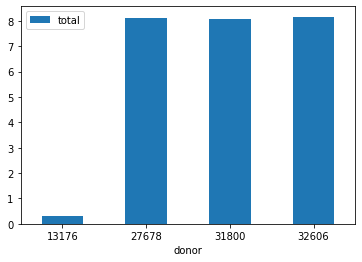

In [9]:
df_agg = y_chr_cols_df.groupby('donor').agg({'total': 'mean'})
df_agg.plot.bar(rot=0)
plt.show()

Let us check the mean values per donor for the first 35 features.

We can see about half of features have exactly zero values for the female donor, without any noise present.
And at the same time, we only see a few features that could be called "a bit noisy", with non-zero mean values for the female donor that are much lower than mean values for male donors.
And surprisingly, there are many very noisy features, with mean values for the female donor cells just a bit lower than for cells from the male donors.
The features are sorted in alphabet order, and many features located close to each other refer to neighboring parts of the same chromosome. We can see that noisy features are often located close to each other.

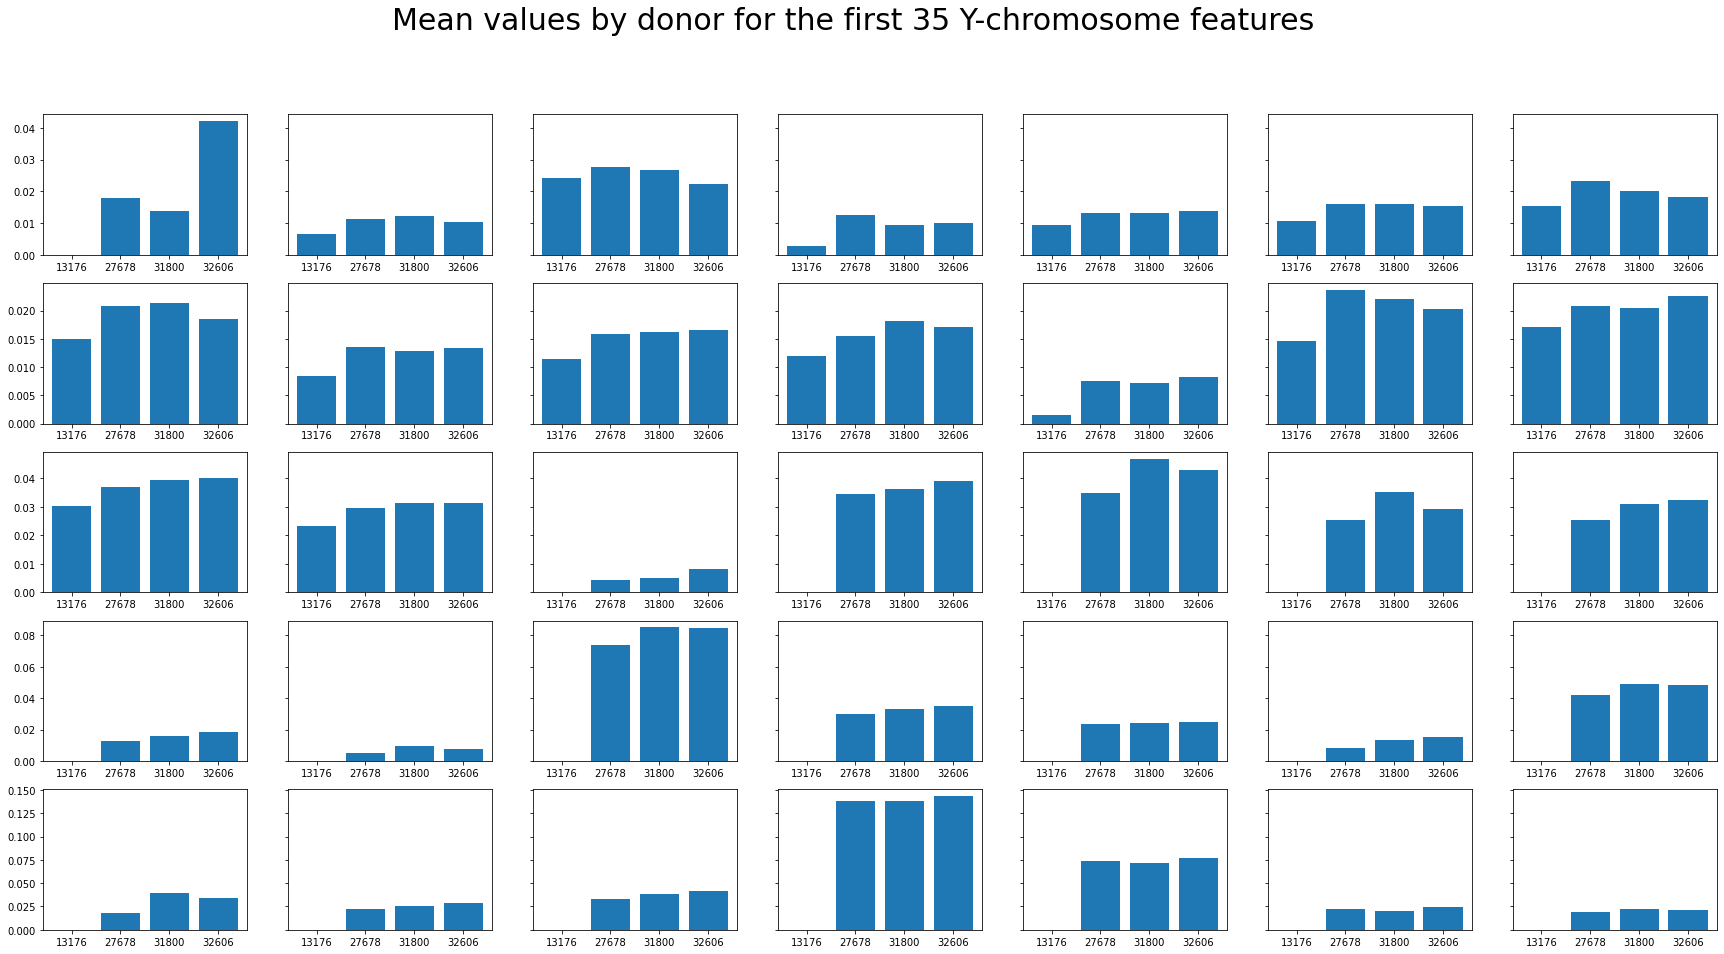

In [10]:
sample_35_columns_mean = { i : 'mean' for i in y_chr_cols[:35] }
df_agg = y_chr_cols_df.groupby('donor').agg(sample_35_columns_mean)
fig, ax = plt.subplots(5, 7, sharey='row', figsize=(30, 15), squeeze=False)
plt.suptitle('Mean values by donor for the first 35 Y-chromosome features', fontsize=30)
for i in range(5):
    for j in range(7):
        k = i*7 + j
        ax[i, j].bar(df_agg.index.astype(str), df_agg[y_chr_cols[k]])

In [11]:
# It would be interesting to visualize several other parameters for the same columns.
# So, it makes sense to write a function for this visualization.

def visualize_columns(data_fr, n_rows, n_cols, sample_features, title_text):
    fig, ax = plt.subplots(n_rows, n_cols, sharey='row', figsize=(30, 15), squeeze=False)
    plt.suptitle(title_text, fontsize=30)
    for i in range(n_rows):
        for j in range(n_cols):
            k = i*n_cols + j
            ax[i, j].bar(data_fr.index.astype(str), data_fr[sample_features[k]])
    

Let us check what are the max values for the same 35 features. It is important to remember that values are TF-IDF normalized so 
maximum values do not really mean maximum number of counts.

We can see that in some cases max values are even higher for the female donor, and for all cases where mean values for the female donor are
non-zero, max values are more or less the same for all donors. This is true even for the features with much lower mean values for 
female donor. It looks like there are noisy and pure features, and the source of noise could be something like misinterpreting the
chromatin accessibility signal from some other part of genome. These findings are quite interesting, although they don't give us any clue how to understand which non-Ychromosome features are noisy.

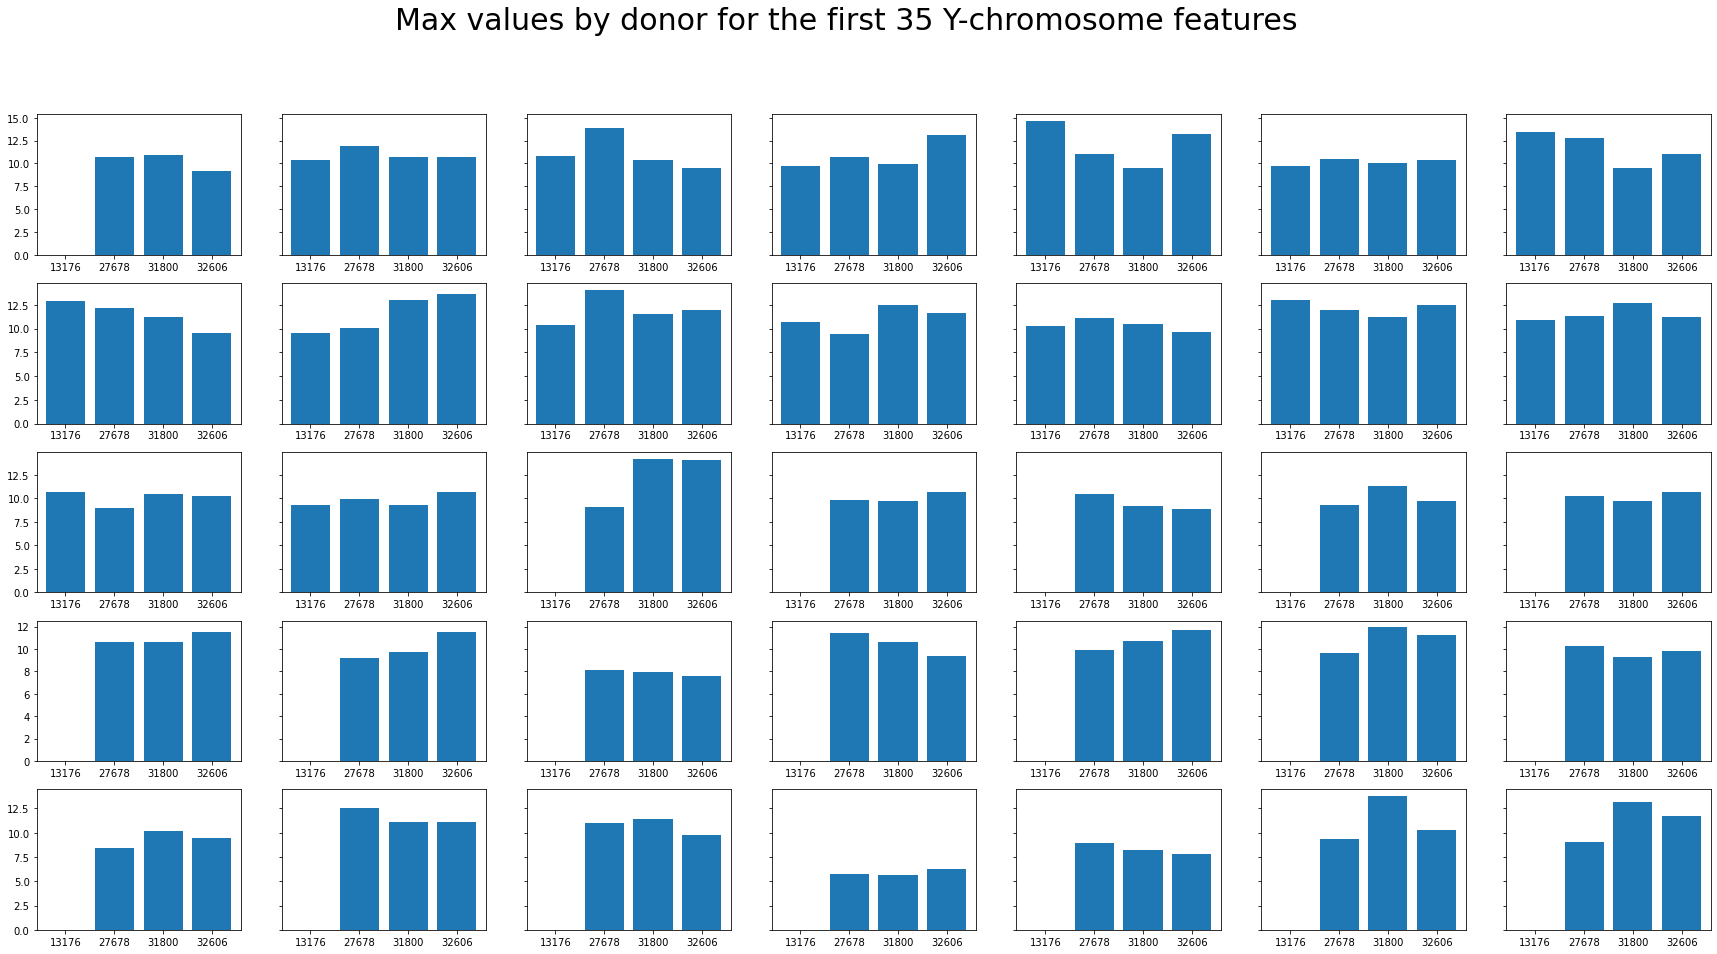

In [12]:
sample_35_columns_max = { i : 'max' for i in y_chr_cols[:35] }
df_agg = y_chr_cols_df.groupby('donor').agg(sample_35_columns_max)
title = 'Max values by donor for the first 35 Y-chromosome features'
visualize_columns(df_agg, 5,7, y_chr_cols[:35], title)

In [13]:
# Now let's have a bit wider look and select all the noisy Y-chromosome features.
# Well, and let's count how many of them are there in the dataset.
noisy_ychr = []
for feature in y_chr_cols:
    if y_chr_cols_df.loc[y_chr_cols_df['donor'] == 13176, feature].mean() > 0:
        noisy_ychr = np.append(noisy_ychr, feature)
print('Total Y-chromosome features: ' + str(len(y_chr_cols)))
print('Noisy Y-chromosome features: ' + str(len(noisy_ychr)))

Total Y-chromosome features: 214
Noisy Y-chromosome features: 21


Now we will look atdistribution of this noise between train and test datasets. Note that for female donor test set only includes day = 10.
We can see no clear pattern. There is a single feature without noise values in train data, but with some noise values in test data.

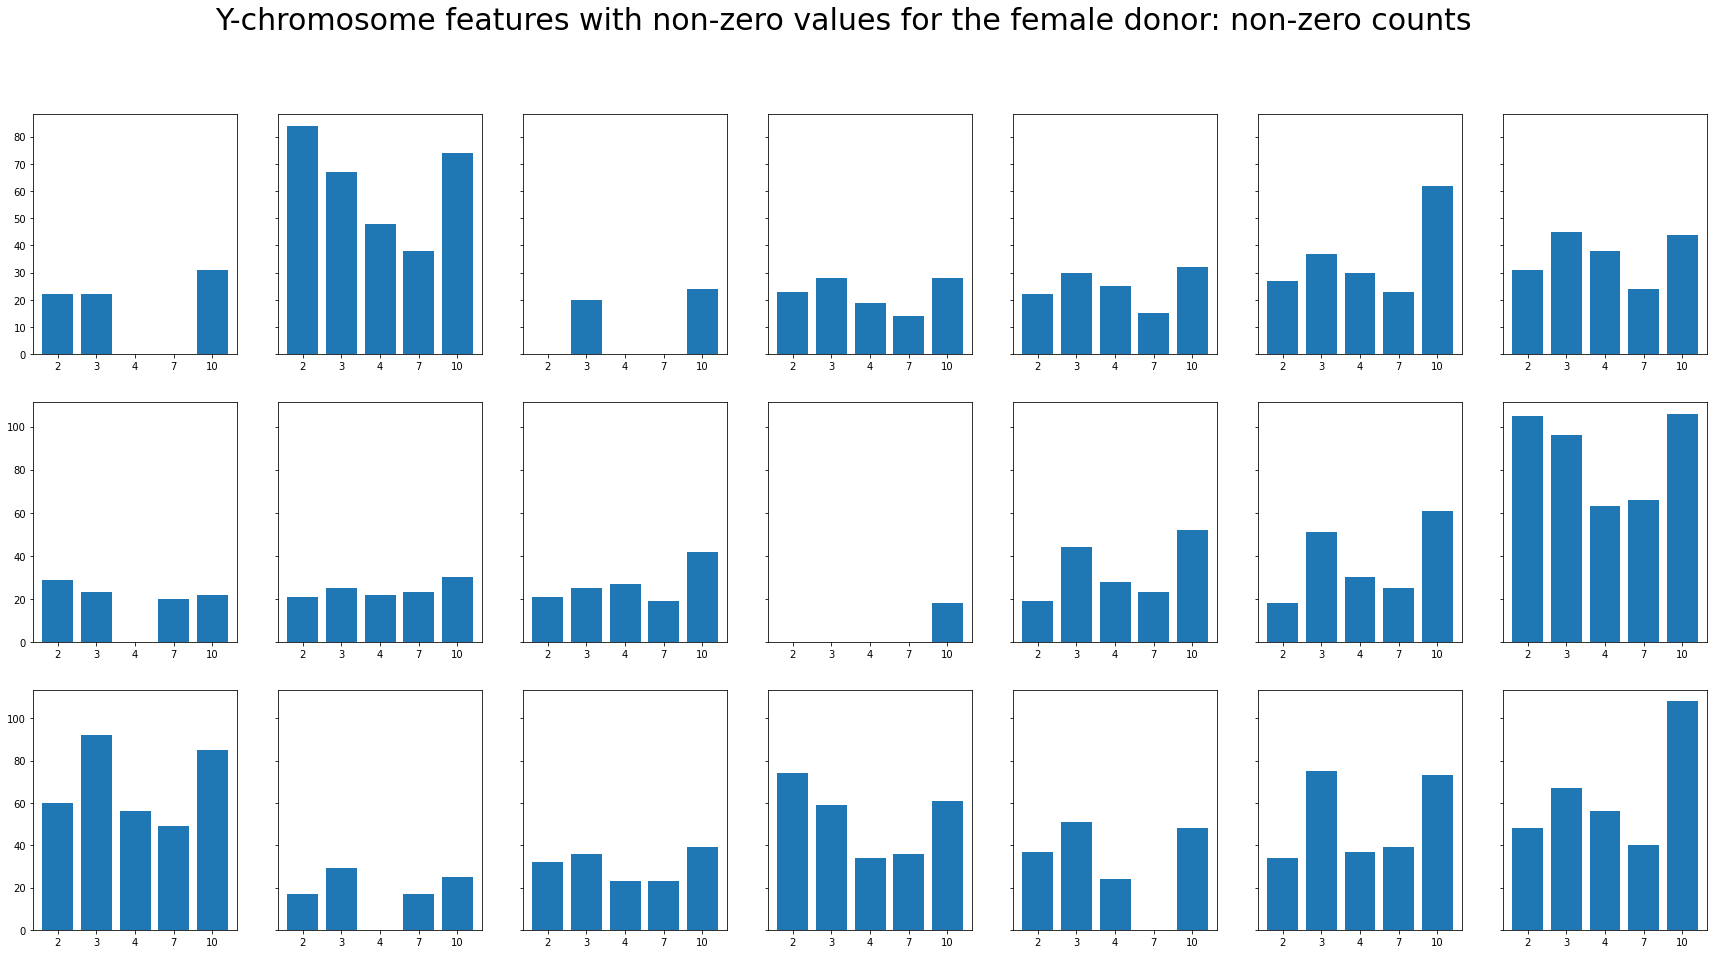

In [14]:
agg_dict = { i : np.count_nonzero for i in noisy_ychr }
df_agg = y_chr_cols_df.loc[y_chr_cols_df['donor'] == 13176].groupby('day').agg(agg_dict)
title = 'Y-chromosome features with non-zero values for the female donor: non-zero counts'
visualize_columns(df_agg, 3, 7, noisy_ychr, title)

In [15]:
%%time
# Now we can check the same parameters for the raw data to understand better what sort of noise is present in 
# raw data.
# Let's start with loading the raw data for Y-chromosome columns.

raw_train_path = '/kaggle/input/open-problems-raw-counts/train_multi_inputs_raw.h5'
raw_test_path = '/kaggle/input/open-problems-raw-counts/test_multi_inputs_raw.h5'
y_chr_raw_cols_df = read_selected_columns_in_chunks(raw_train_path, y_chr_cols, 10000)
y_chr_raw_cols_df = read_selected_columns_in_chunks(raw_test_path, y_chr_cols, 10000, y_chr_raw_cols_df)
gc.collect()

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
CPU times: user 8min 14s, sys: 1min 3s, total: 9min 18s
Wall time: 9min 36s


59610

In [16]:
# There is no info for a few cells in the raw data. So, we have to make an inner join here.
# This will lead to raw dataframe having a few columns less, compared to the dataframe with pre-processed data.
md_df = pd.read_csv(FP_CELL_METADATA, index_col='cell_id')
md_df = md_df.loc[md_df['technology'] == "multiome"]
md_df['day'] = md_df['day'].astype('int8')
del md_df['technology']
y_chr_raw_cols_df = y_chr_raw_cols_df.join(md_df, how = 'inner', on = 'cell_id')
del md_df
gc.collect()

21

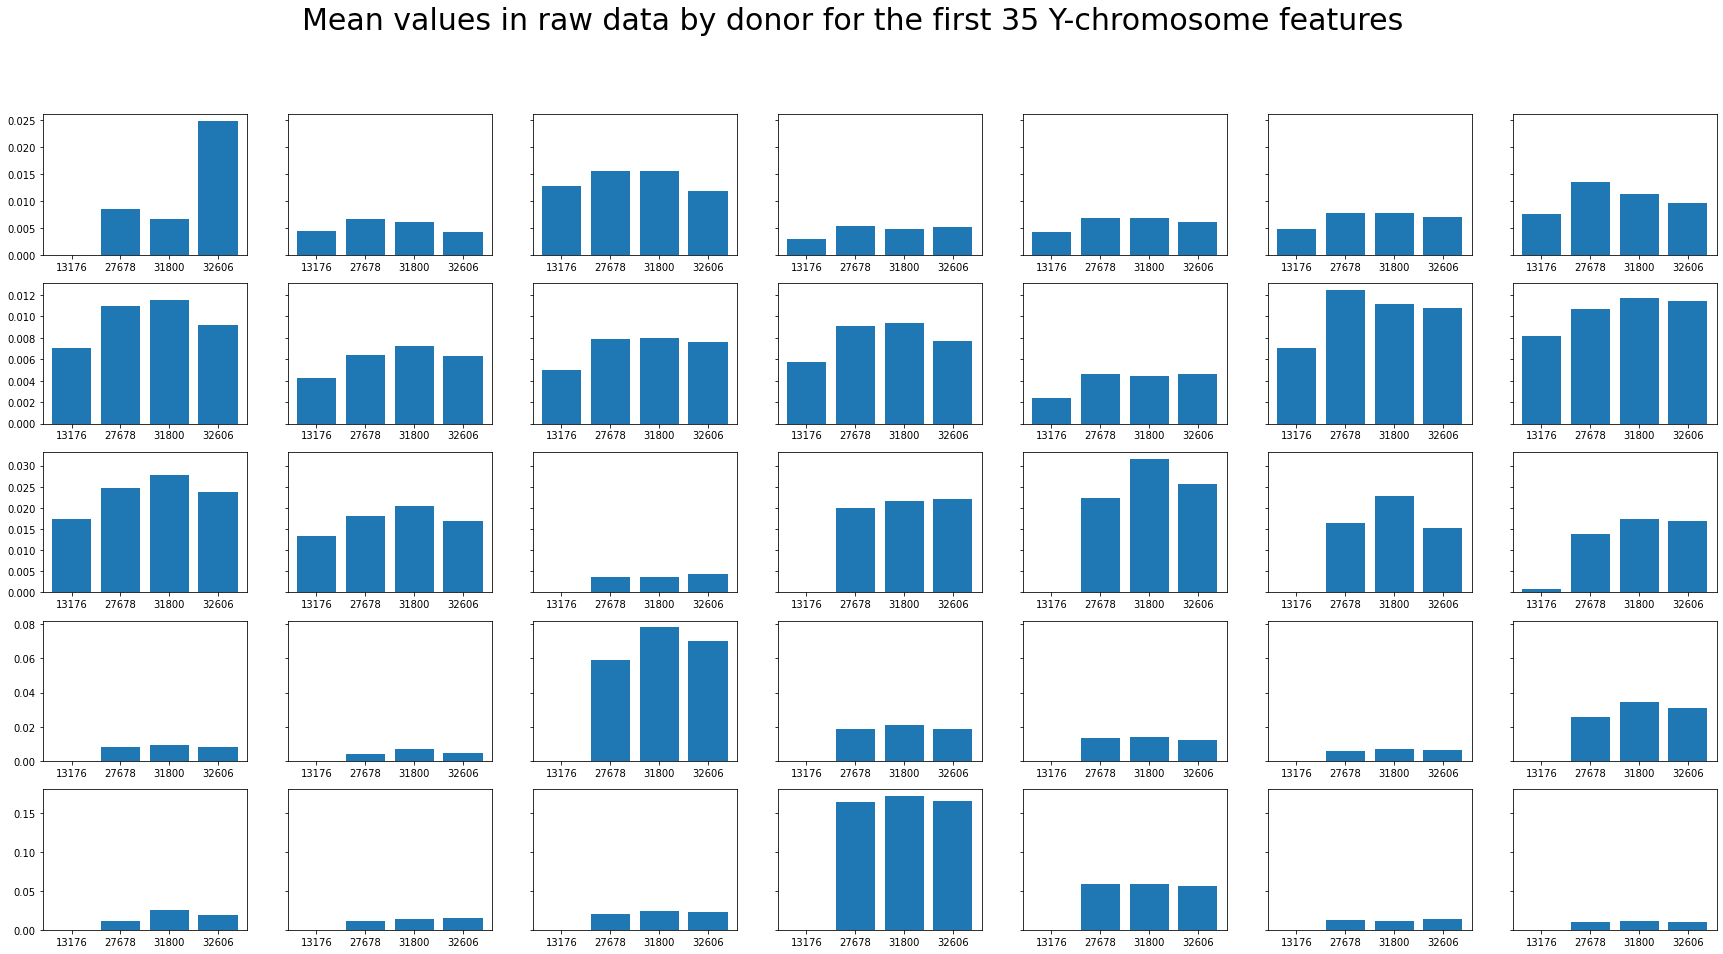

In [17]:
# Now let's check the same 35 Y-chromosome related inputs in raw data. 
# We can see that, surprisingly, some features that didn't have a single non-zero value in normalized data do 
# have some non-zero values in raw data.

df_agg = y_chr_raw_cols_df.groupby('donor').agg(sample_35_columns_mean)
title = 'Mean values in raw data by donor for the first 35 Y-chromosome features'
visualize_columns(df_agg, 5,7, y_chr_cols[:35], title)

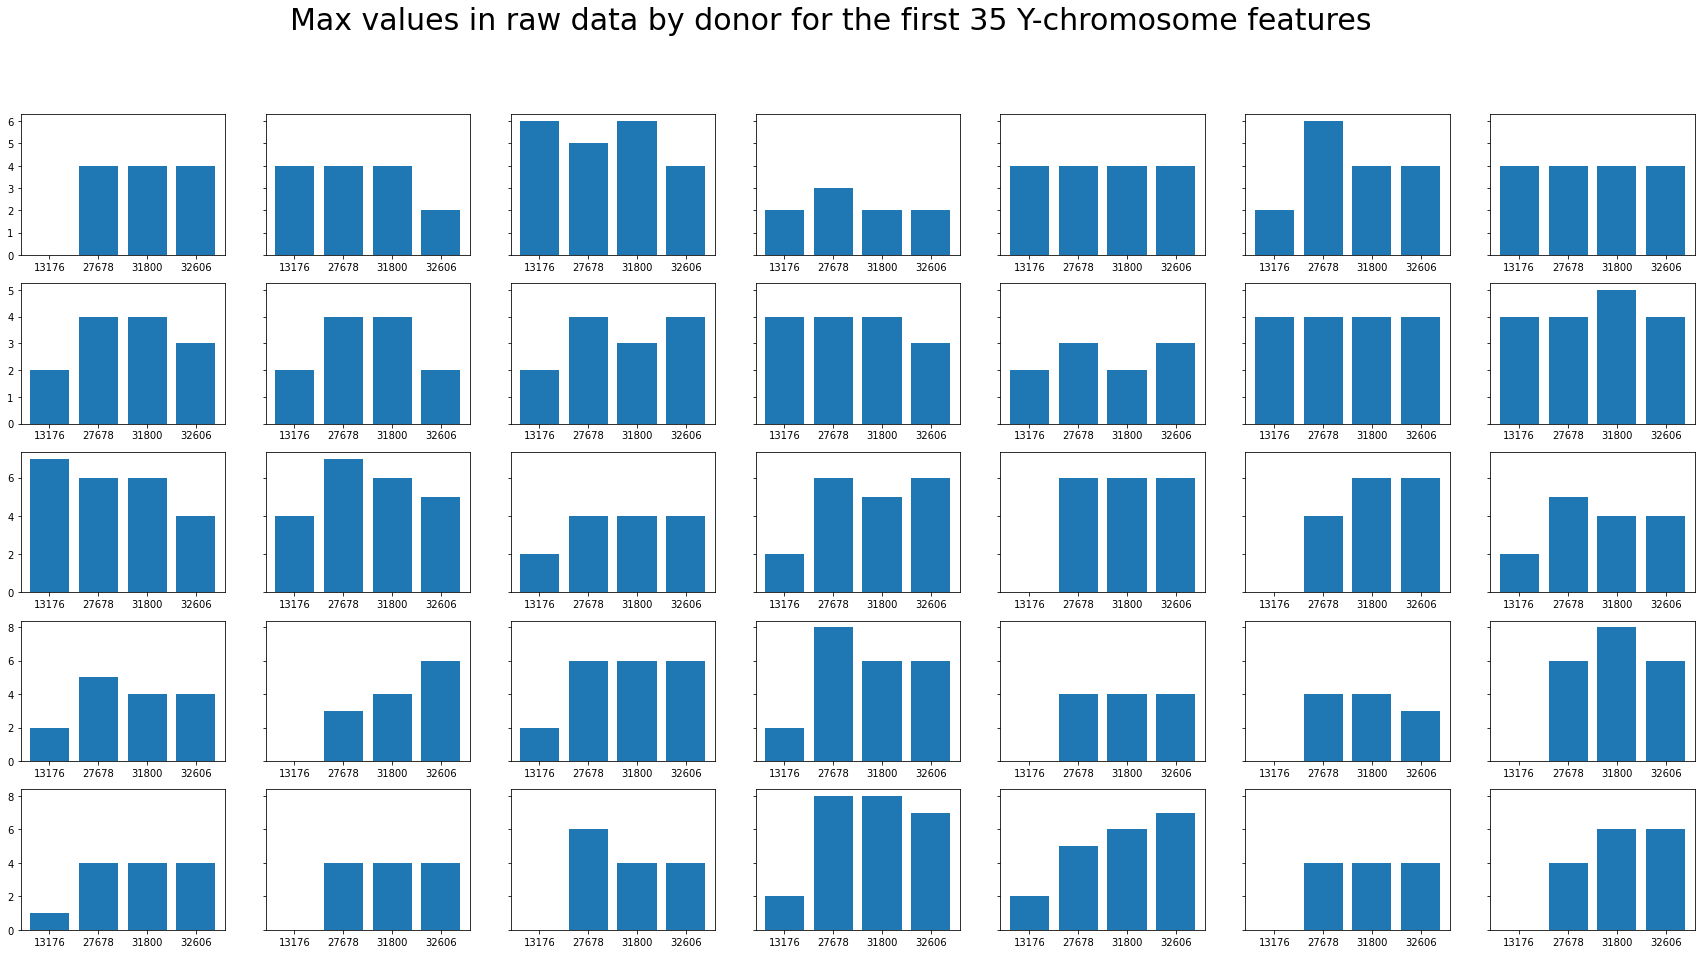

In [18]:
# Max values give us a clue about how the data was cleaned before TF-IDF normalization.
df_agg = y_chr_raw_cols_df.groupby('donor').agg(sample_35_columns_max)
title = 'Max values in raw data by donor for the first 35 Y-chromosome features'
visualize_columns(df_agg, 5,7, y_chr_cols[:35], title)

In [19]:
# Now let's count the noisy columns in raw data.
# There are total 77 features with some noise present, a bit more than one third of all Y-chromosome features.
# Still, about two thirds of columns contained no noise even in raw data.
# And just 21 columns have high level of noise that couldn't be cleared in pre-processing.
noisy_ychr_raw = []
for feature in y_chr_cols:
    if y_chr_raw_cols_df.loc[y_chr_raw_cols_df['donor'] == 13176, feature].mean() > 0:
        noisy_ychr_raw = np.append(noisy_ychr_raw, feature)
print('Total Y-chromosome features: ' + str(len(y_chr_cols)))
print('Noisy Y-chromosome features in raw data: ' + str(len(noisy_ychr_raw)))
print('Noisy Y-chromosome features in regular data: ' + str(len(noisy_ychr)))

Total Y-chromosome features: 214
Noisy Y-chromosome features in raw data: 77
Noisy Y-chromosome features in regular data: 21


Now let's return to the feature that only had a noise values for a single day - a day used as a test set.

It is 'chrY:11323123-11323623'.

Let's compare number of non-zero values for this feature in raw and pre-processed data.

We see the same number of non-zero-values for day 10, while for all other days non-zero values are only present in raw data. It looks like during pre-processing organizers looked at number of non-zero values per feature, per donor, per day. If it was less than the threshold value, all the values for that feature for the day/donor were set to zero. The threshold value must be somewhere between 14 and 18.

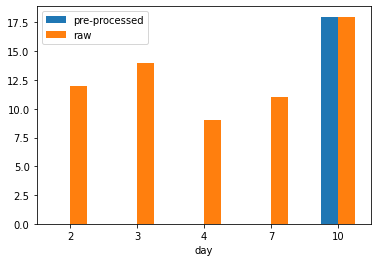

In [20]:
per_day_reg = y_chr_cols_df.loc[y_chr_cols_df['donor'] == 13176].groupby('day').agg({'chrY:11323123-11323623' : np.count_nonzero})
per_day_raw = y_chr_raw_cols_df.loc[y_chr_raw_cols_df['donor'] == 13176].groupby('day').agg({'chrY:11323123-11323623' : np.count_nonzero})
df_agg = pd.DataFrame({'pre-processed': per_day_reg['chrY:11323123-11323623'],
                       'raw': per_day_raw['chrY:11323123-11323623']}, index=per_day_raw.index)
ax = df_agg.plot.bar(rot=0)

Now we will check the Y-chromosome multiome targets / CITE inputs. Here, we will use the ensembl_rest API to get information about genes' actual locations on DNA. Here we will run ensembl_rest API for all the multiome targets and save the data into a file as running the ensembl_rest API takes time, especially if you try to run it during workweek. We will also save some more data, not just the chromosomes, so that this information could be used later.

In [21]:
# Make a list of all multiome target's names.
df_targets = pd.read_hdf(FP_MULTIOME_TRAIN_TARGETS, start=0, stop=10)
multiome_targets = df_targets.columns
del df_targets
gc.collect()
print("Total multiome targets: " + str(len(multiome_targets)))

Total multiome targets: 23418


In [22]:
%%time
# And now get the data from API.

df_target_info = pd.DataFrame({'columns': multiome_targets})
df_target_info['chromosome'] = 'error'
df_target_info['start'] = 0
df_target_info['end'] = 0
for i in range(len(multiome_targets)):
    try:
        full_data = ensembl_rest.sequence_id(multiome_targets[i])
        df_target_info['chromosome'].iloc[i] = re.split('\:', full_data['desc'])[2]
        df_target_info['start'].iloc[i] = int(re.split('\:', full_data['desc'])[3])
        df_target_info['end'].iloc[i] = int(re.split('\:', full_data['desc'])[4])
        if str(i).endswith('000'):
            print(str(i))
    except:
        print(multiome_targets[i] + '_error')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


ENSG00000285162_error
ENSG00000261490_error
ENSG00000264608_error
ENSG00000267776_error
ENSG00000237513_error
ENSG00000239467_error
ENSG00000236886_error
ENSG00000275560_error
ENSG00000271815_error
1000
ENSG00000256427_error
ENSG00000272040_error
ENSG00000267034_error
ENSG00000278198_error
ENSG00000273496_error
ENSG00000259298_error
ENSG00000259618_error
ENSG00000273466_error
ENSG00000224739_error
ENSG00000270195_error
ENSG00000226380_error
ENSG00000285106_error
ENSG00000224959_error
ENSG00000273837_error
ENSG00000269894_error
ENSG00000280374_error
ENSG00000237133_error
ENSG00000259939_error
ENSG00000260276_error
ENSG00000274307_error
ENSG00000271870_error
ENSG00000288436_error
ENSG00000215159_error
ENSG00000269899_error
ENSG00000254615_error
2000
ENSG00000287686_error
ENSG00000224745_error
ENSG00000287388_error
ENSG00000272440_error
ENSG00000286699_error
ENSG00000226377_error
ENSG00000253878_error
ENSG00000272923_error
ENSG00000274031_error
ENSG00000272354_error
ENSG00000237838_error


In [23]:
# This code can be used to save the dataframe with target info to a local file. So, that you didn't have to wait 
# for the API to run once again.

target_info_path = 'target_info.csv'
df_target_info.to_csv(target_info_path, encoding='utf-8', index=False)
FileLink(target_info_path)

/kaggle/working/target_info.csv

In [24]:
# And this code can be used to load the same dataframe from a file.
df_target_info = pd.read_csv('/kaggle/input/single-cell-multiome-target-info/target_info.csv')

In [25]:
# Let's check number of Y-Chromosome located genes among multiome targets.
y_chr_targets = list(df_target_info.loc[df_target_info['chromosome'] == 'Y', 'columns'])
print("Total number of Y-Chromosome located genes among multiome targets: " + str(len(y_chr_targets)))

Total number of Y-Chromosome located genes among multiome targets: 22


In [26]:
# Multiome targets can be fitted into memory altogether, so, we will load them all and then remove those located
# on other chromosomes.It will be more convenient to join altogether metadata and data for both pre-processed 
# and raw Y-chromosome located targets into a single dataframe.
df_targets = pd.read_hdf(FP_MULTIOME_TRAIN_TARGETS)
df_targets = df_targets[y_chr_targets]
                        
df_raw_targets = pd.read_hdf('/kaggle/input/open-problems-raw-counts/train_multi_targets_raw.h5')
df_raw_targets = df_raw_targets[y_chr_targets]
df_raw_targets = df_raw_targets.add_prefix('raw_')
df_targets = df_targets.join(df_raw_targets, how = 'inner', on = 'cell_id')
                                
md_df = pd.read_csv(FP_CELL_METADATA, index_col='cell_id')
md_df = md_df.loc[md_df['technology'] == "multiome"]
md_df['day'] = md_df['day'].astype('int8')
del md_df['technology']
df_targets = df_targets.join(md_df, how = 'inner', on = 'cell_id')
del md_df, df_raw_targets

gc.collect()


58

In [27]:
# Now, let's count noisy columns in multiome targets.
# We can see the same number of columns in both raw and pre-processed data have some noise.
# 18 out of 22 columns have exactly zero noise even in raw data.
# There are noisy and noise-free columns, just like in multiome inputs.
# But it doesn't look like there was any noise cleaning before normalization here.

y_chr_targets_raw = ['raw_' + s for s in y_chr_targets]
noisy_ychr = []
noisy_ychr_raw = []
for feature in y_chr_targets:
    if df_targets.loc[df_targets['donor'] == 13176, feature].mean() > 0:
        noisy_ychr = np.append(noisy_ychr, feature)
for feature in y_chr_targets_raw:
    if df_targets.loc[df_targets['donor'] == 13176, feature].mean() > 0:
        noisy_ychr_raw = np.append(noisy_ychr_raw, feature)
print('Total Y-chromosome targets: ' + str(len(y_chr_targets)))
print('Noisy Y-chromosome targets in raw data: ' + str(len(noisy_ychr_raw)))
print('Noisy Y-chromosome targets in pre-processed data: ' + str(len(noisy_ychr)))


Total Y-chromosome targets: 22
Noisy Y-chromosome targets in raw data: 4
Noisy Y-chromosome targets in pre-processed data: 4


In [28]:
# Now it's time to focus on those 4 features with some noise.
# Again, let's compare number of non-zero values for raw and processed data.
total_list = np.append(noisy_ychr,noisy_ychr_raw)
agg_dict = { i : np.count_nonzero for i in total_list }
df_agg = df_targets.loc[df_targets['donor'] == 13176].groupby('day').agg(agg_dict)

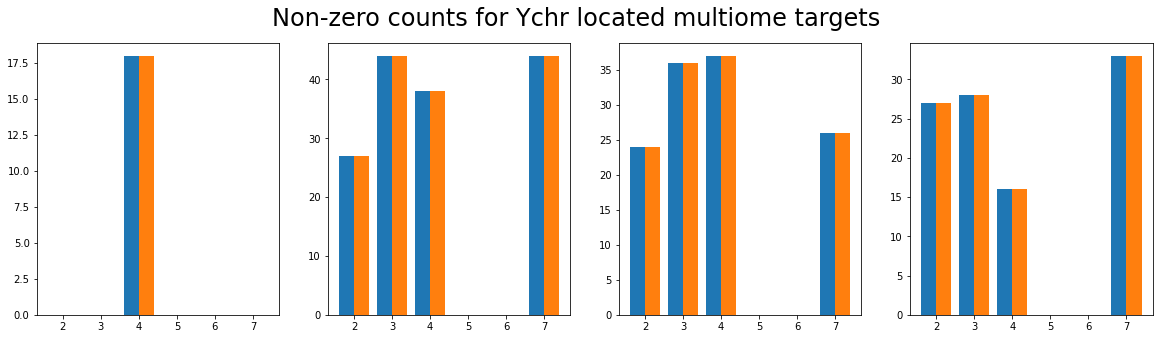

In [29]:
# Number pf non-zero values is exactly the same for raw and pre-processed targets.
# So, multiome targets were preprocessed differently - unlike inputs, no values were set to be equal to zero.
fig, axs = plt.subplots(1,4, figsize=(20, 5))
fig.suptitle('Non-zero counts for Ychr located multiome targets', fontsize=24)
for i in range(4):
    axs[i].bar(df_agg.index -0.2, df_agg[noisy_ychr_raw[i]], width=0.4)
    axs[i].bar(df_agg.index +0.2, df_agg[noisy_ychr[i]], width=0.4)
plt.show()

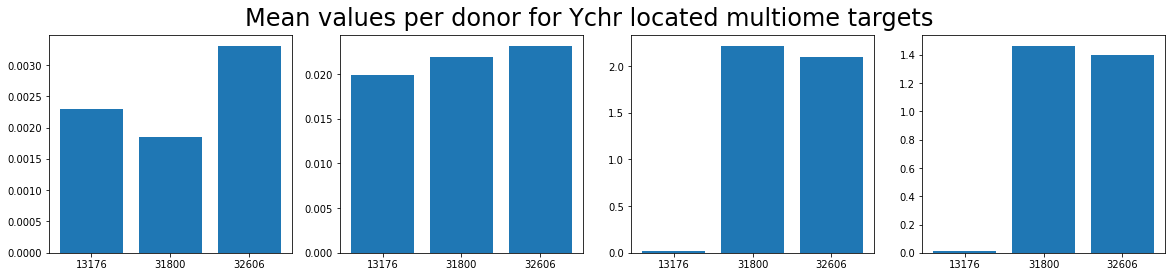

In [30]:
# We have one more check left. Let's see the average values per donor for that noisy targets.
# We can see, there is little noise in two out of four noisy columns, while the other two columns have almost 
# the same values for male and female donors. Likely, this means that values for male donors are also mostly 
# noise.
mean_for_noisy = { i : 'mean' for i in noisy_ychr}
df_agg = df_targets.groupby('donor').agg(mean_for_noisy)
fig, axs = plt.subplots(1,4, figsize=(20, 4))
fig.suptitle('Mean values per donor for Ychr located multiome targets', fontsize=24)
for i in range(4):
    axs[i].bar(df_agg.index.astype(str), df_agg[noisy_ychr[i]])
plt.show()

# **Conclusions part 1**
First of all, we understood that donor 13176 is female, while all other donors are male. And there are obvious ways to exploit this knowledge by adding a corresponding feature.

Then, we've learned that both multiome inputs and multiome targets / CITE inputs have both noisy and noiseless columns. When it comes to multiome inputs, organizers tried to reduce noise levels by setting feature values to zero if they were almost always zero for the same day / donor. A potentially very important fact is that noisy features often refer to neighboring parts of genome.

# **Part 2. Targets corresponding to features**
We know that each RNA molecule is produced using genetic data stored in a specific part of DNA. So, the obvious idea would be that availability of some specific part of DNA could lead to high levels of corresponding gene expression. So, let's look into the data and check correlation between multiome features and targets that refer to same parts of genome.

In [31]:
# First we will create a dataframe with all the data from multiome input names.
df_names_processed = pd.DataFrame({'columns': all_multiome_inputs})
df_names_processed['chromosome'] = [re.split('\:', w)[0].replace('chr', '') for w in df_names_processed['columns']]
df_names_processed['start-end'] = [re.split('\:', w)[1] for w in df_names_processed['columns']]
df_names_processed['start'] = [int(re.split('-', w)[0]) for w in df_names_processed['start-end']]
df_names_processed['end'] = [int(re.split('-', w)[1]) for w in df_names_processed['start-end']]
df_names_processed['length'] = df_names_processed['end'] - df_names_processed['start']
del df_names_processed['start-end']
df_target_info['length'] = df_target_info['end'] - df_target_info['start']

df_names_processed['target_start'] = 'None'
df_names_processed['target_middle'] = 'None'
df_names_processed['target_end'] = 'None'

In [32]:
# Now we will find a corresponding input for every target.
for i in tqdm(range(len(df_target_info)), desc='Finding corresponding inputs'):
    target_start = df_target_info['start'].iloc[i]
    target_end = df_target_info['end'].iloc[i]
    target_chr = df_target_info['chromosome'].iloc[i]
    target_column = df_target_info['columns'].iloc[i]
    index_start = df_names_processed.loc[(df_names_processed['start'] <= target_start) &  (df_names_processed['end'] >= target_start) &
                          (df_names_processed['chromosome'] == target_chr)].index
    index_middle = df_names_processed.loc[(df_names_processed['start'] >= target_start) &  (df_names_processed['end'] <= target_end) &
                          (df_names_processed['chromosome'] == target_chr)].index
    index_end = df_names_processed.loc[(df_names_processed['start'] <= target_end) &  (df_names_processed['end'] >= target_end) &
                          (df_names_processed['chromosome'] == target_chr)].index
    if len(index_start) > 0:
        df_names_processed.iloc[index_start, 5] = target_column
    if len(index_middle) > 0:
        df_names_processed.iloc[index_middle, 6] = target_column
    if len(index_end) > 0:
        df_names_processed.iloc[index_end, 7] = target_column

Finding corresponding inputs: 100%|██████████| 23418/23418 [26:18<00:00, 14.84it/s]


In [33]:
# It took some time to build that dataframe, so we should better save it to file.
processed_names_path = 'processed_names.csv'
df_names_processed.to_csv(processed_names_path, encoding='utf-8', index=False)
FileLink(processed_names_path)

/kaggle/working/processed_names.csv

In [34]:
# And this code can be used to load the same dataframe from a file.
df_names_processed = pd.read_csv('/kaggle/input/single-cell-multiome-target-info/processed_names.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [35]:
# Let up now see a bit of statistics for the inputs and targets.
total_inputs = len(df_names_processed)
inputs_no_target = len(df_names_processed.loc[(df_names_processed['target_middle'] == 'None')
                                              & (df_names_processed['target_start'] == 'None')
                                              & (df_names_processed['target_end'] == 'None')])
inputs_target_middle = len(df_names_processed.loc[df_names_processed['target_middle'] == 'None'])
total_targets = len(df_target_info)
corresponding_targets = len(pd.unique(df_names_processed[['target_start', 'target_middle', 'target_end']].values.ravel('K')))
targets_middle_count = df_names_processed['target_middle'].nunique()
targets_middle_average_inputs = inputs_target_middle / targets_middle_count
print(f'Total inputs: {total_inputs}')
print(f'Average input length (in nucleotids): {df_names_processed["length"].mean():.2f}')
print(f'Inputs not corresponding to a single target: {inputs_no_target}')
print(f'Total targets: {total_targets}')
print(f'Average target length (in nucleotids): {df_target_info["length"].mean():.2f}')
print(f'Targets with at least one corresponding featue: {corresponding_targets}')
print(f'Targets with at least one corresponding featue in the middle: {targets_middle_count}')
print(f'Average number of "middle" features per target: {targets_middle_average_inputs:.2f}')      

Total inputs: 228942
Average input length (in nucleotids): 836.19
Inputs not corresponding to a single target: 79393
Total targets: 23418
Average target length (in nucleotids): 69683.79
Targets with at least one corresponding featue: 20272
Targets with at least one corresponding featue in the middle: 16444
Average number of "middle" features per target: 5.53


We can see that targets are much longer than features, with one target on average being about 100 times longer (in nucleotids)
than an average input. This also means in the best case we only know availability of small chunks of DNA, corresponding to a target. For almost 80000 targets we do not now anything about availability of corresponding parts of DNA.

But correlation between targets and inputs is most important for us as it could help us improve prediction.
We can only check correlation on part of data or on part of features as it's impossible to load all the train inputs into memory.
Let's take a random sample of targets and check correlation between those targets and all the corresponding features.

In [36]:
sample_targets = sample(list(df_target_info['columns']),3000)
sample_inputs = []
for i in range(len(df_names_processed)):
    if (df_names_processed.iloc[i, 6] in sample_targets) | (df_names_processed.iloc[i, 5] in sample_targets) | (df_names_processed.iloc[i, 7] in sample_targets):
        sample_inputs.append(df_names_processed.iloc[i, 0])


In [37]:
# It is possible to load all the sample inputs.
sample_inputs_df = read_selected_columns_in_chunks(FP_MULTIOME_TRAIN_INPUTS, sample_inputs, 10000)
gc.collect()

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


103292

In [38]:
# And now the sample targets.
df_targets = pd.read_hdf(FP_MULTIOME_TRAIN_TARGETS)
df_targets = df_targets[sample_targets]
gc.collect()

79

In [39]:
# Calculate the correlations.
df_names_processed['corr_start'] = 0.0
df_names_processed['corr_middle'] = 0.0
df_names_processed['corr_end'] = 0.0

for i in range(len(df_names_processed)):
    if df_names_processed.iloc[i, 5] in sample_targets:
        input_col = df_names_processed.iloc[i, 0]
        target_col = df_names_processed.iloc[i, 5]
        df_names_processed.iloc[i, 8] = np.corrcoef(sample_inputs_df[input_col], df_targets[target_col])[1, 0]
    if df_names_processed.iloc[i, 6] in sample_targets:
        input_col = df_names_processed.iloc[i, 0]
        target_col = df_names_processed.iloc[i, 6]
        df_names_processed.iloc[i, 9] = np.corrcoef(sample_inputs_df[input_col], df_targets[target_col])[1, 0]
    if df_names_processed.iloc[i, 7] in sample_targets:
        input_col = df_names_processed.iloc[i, 0]
        target_col = df_names_processed.iloc[i, 7]
        df_names_processed.iloc[i, 10] = np.corrcoef(sample_inputs_df[input_col], df_targets[target_col])[1, 0]

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [40]:
# We can see that less than 1% of targets have more than 0.1 correlation with inputs.
df_names_processed.loc[(df_names_processed['corr_start'] > 0.1)  | (df_names_processed['corr_middle'] > 0.1) | (df_names_processed['corr_end'] > 0.1) ]

,columns,chromosome,start,end,length,target_start,target_middle,target_end,corr_start,corr_middle,corr_end
13675,chr11:126400215-126401110,11,126400215,126401110,895,None,ENSG00000110080,None,0.0,0.114883,0.000000
47936,chr15:39597674-39598506,15,39597674,39598506,832,None,ENSG00000137801,None,0.0,0.154715,0.000000
83183,chr19:8499900-8500808,19,8499900,8500808,908,None,ENSG00000133246,None,0.0,0.103223,0.000000
102065,chr1:65292747-65293657,1,65292747,65293657,910,None,ENSG00000116675,None,0.0,0.194423,0.000000
102067,chr1:65317611-65318514,1,65317611,65318514,903,None,ENSG00000116675,None,0.0,0.122506,0.000000
125635,chr2:189581810-189582544,2,189581810,189582544,734,None,ENSG00000138449,None,0.0,0.111785,0.000000
147348,chr3:19702337-19703231,3,19702337,19703231,894,None,None,ENSG00000287069,0.0,0.000000,0.127653
195258,chr7:150955439-150956350,7,150955439,150956350,911,None,ENSG00000055118,None,0.0,0.144094,0.000000
195260,chr7:150959970-150960807,7,150959970,150960807,837,None,ENSG00000055118,None,0.0,0.117423,0.000000
211514,chr8:74295474-74296366,8,74295474,74296366,892,None,ENSG00000104369,None,0.0,0.109410,0.000000


In [41]:
# Now, let's check if raw data is better correlated.
del sample_inputs_df
gc.collect()
sample_inputs_df = read_selected_columns_in_chunks(raw_train_path, sample_inputs, 10000)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [42]:
# Now we will join raw inputs and targets into a single dataframe, as raw input data lacks info on some cells.
df = pd.merge(sample_inputs_df, df_targets, how='inner', on='cell_id')
del sample_inputs_df, df_targets
gc.collect()

386

In [43]:
# Calculate the same correlations, but for raw data.
df_names_processed['corr_start'] = 0.0
df_names_processed['corr_middle'] = 0.0
df_names_processed['corr_end'] = 0.0

for i in range(len(df_names_processed)):
    if df_names_processed.iloc[i, 5] in sample_targets:
        input_col = df_names_processed.iloc[i, 0]
        target_col = df_names_processed.iloc[i, 5]
        df_names_processed.iloc[i, 8] = np.corrcoef(df[input_col], df[target_col])[1, 0]
    if df_names_processed.iloc[i, 6] in sample_targets:
        input_col = df_names_processed.iloc[i, 0]
        target_col = df_names_processed.iloc[i, 6]
        df_names_processed.iloc[i, 9] = np.corrcoef(df[input_col], df[target_col])[1, 0]
    if df_names_processed.iloc[i, 7] in sample_targets:
        input_col = df_names_processed.iloc[i, 0]
        target_col = df_names_processed.iloc[i, 7]
        df_names_processed.iloc[i, 10] = np.corrcoef(df[input_col], df[target_col])[1, 0]

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


We can see about 50% increase in number of inputs having correlation above 0.1, but that still makes less than 1% of all targets.
I made this experiment several times, and each time there were more correlating features in raw data. This likely means some important information was lost in pre-processing.


In [44]:
df_names_processed.loc[(df_names_processed['corr_start'] > 0.1)  | (df_names_processed['corr_middle'] > 0.1) | (df_names_processed['corr_end'] > 0.1) ]

,columns,chromosome,start,end,length,target_start,target_middle,target_end,corr_start,corr_middle,corr_end
12181,chr11:114059177-114059989,11,114059177,114059989,812,None,ENSG00000109906,None,0.0,0.104128,0.000000
12187,chr11:114082549-114083459,11,114082549,114083459,910,None,ENSG00000109906,None,0.0,0.108597,0.000000
13675,chr11:126400215-126401110,11,126400215,126401110,895,None,ENSG00000110080,None,0.0,0.121961,0.000000
47936,chr15:39597674-39598506,15,39597674,39598506,832,None,ENSG00000137801,None,0.0,0.141175,0.000000
49429,chr15:55220949-55221858,15,55220949,55221858,909,None,ENSG00000069974,None,0.0,0.100888,0.000000
49437,chr15:55250250-55251092,15,55250250,55251092,842,None,ENSG00000069974,None,0.0,0.102145,0.000000
55499,chr16:20673871-20674779,16,20673871,20674779,908,None,ENSG00000005187,None,0.0,0.105421,0.000000
60464,chr16:85381697-85382618,16,85381697,85382618,921,None,ENSG00000131149,None,0.0,0.108612,0.000000
83182,chr19:8493963-8494859,19,8493963,8494859,896,None,ENSG00000133246,None,0.0,0.113968,0.000000
83183,chr19:8499900-8500808,19,8499900,8500808,908,None,ENSG00000133246,None,0.0,0.123710,0.000000


In [45]:
del df
gc.collect()

42

# **Conclusions part 2**
We saw that both raw and pre-processed multiome features rarely have significant correlation to corresponding targets. While raw features correlate slightly better and that gives us a hint that some important information could be lost in pre-processing.

# **Part 3. A quick look at CITE results**
A quick look at model's results for CITE part of the project and a few thoughts on what that could mean.

In [46]:
df_cite_results = pd.read_csv('/kaggle/input/model-groups/mse_corr (22).csv')
corr_cols = [col for col in df_cite_results.columns if col.endswith('_corr')]
df_cite_results['mean_corr'] = df_cite_results[corr_cols].mean(axis=1)

There are 140 targets in CITE task - these are 140 surface proteins in a cell. I've just loaded file with Pearson correlation values between ground trith and predicted values. In "mean_corr" column there are calculated average correlation values for all folds. We can see that for some targets we get pretty good results, with correlation between predicted values and ground truth values about 0.9. But at the same there is an even larger group of targets with predicted values barely correlating to the ground truth - with correlation about 0.1. Data required to predict values for those targets could be not in the dataset.

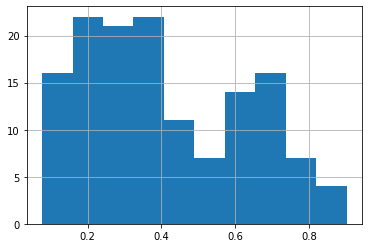

In [47]:
df_cite_results['mean_corr'].hist()
plt.show()

In [48]:
mse_cols = [col for col in df_cite_results.columns if col.endswith('_mse')]
df_cite_results['mean_rmse'] = df_cite_results[mse_cols].mean(axis=1)

We can see, that contrary to what one would expect, in most cases CITE targets with higher RMSE on cross-validation better correlate to the target. One of possible explanations of this fact could be that the equipment is unable to precisely measure amount of rare surface proteins in a cell, and low values for CITE targets are mostly noise.

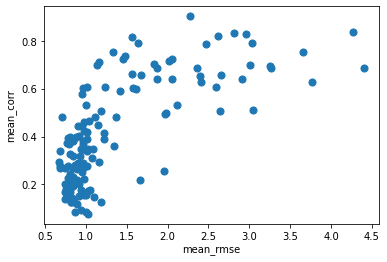

In [49]:
df_cite_results.plot.scatter(x = 'mean_rmse', y = 'mean_corr', s = 50)
plt.show()

# **Conclusions (all parts)**
We found out that one of three donors is a female and used that information to check the data for noise. We found out that while most multiome inputs and multiome targets / CITE inputs are have little to no noise, there are also some really noisy features. We didn't find a way to differenciate between noisy and noise-free features - except for those located on Y-chromosome.

We also found out that in most cases there is little or no correlation between DNA availability and counts for the corresponding RNA.

And we have also found some evidence of highly varying level of noise in CITE targets.